## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [0]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [0]:
train, test = keras.datasets.cifar10.load_data()

In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
from keras.layers import Input, Dense, BatchNormalization
from keras.models import Model
from keras.activations import relu

def add_layers(x, layer1, layer2):
  x = layer1(x)
  x = layer2(x)
  return x

def build_mlp(input_dim, output_dim = 10, hidden_layers = [256, 128, 64], 
              inverse = False, infront_input = False):
  
  input_layer = Input(input_dim)

  x = input_layer
  for i, neurons in enumerate(hidden_layers):
    x = Dense(neurons)(x)
    #x = BatchNormalization()(x)
    if inverse == True and ((i != 0) or infront_input):
      add_layers(x, BatchNormalization(), relu)
    else:
      add_layers(x, relu, BatchNormalization())
    
  out = Dense(output_dim, activation = 'softmax')(x)

  model = Model(input_layer, [out])

  return model

In [0]:
"""Code Here
設定超參數
"""
batch_size = [32, 128, 256]

In [15]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for num in batch_size:
  keras.backend.clear_session()

  name = 'Batch size:%d'%num
  print(name)
  
  model = build_mlp(input_dim = x_train.shape[1:])
  model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam') 

  model.summary()

  model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10, batch_size = num, shuffle=True)

  acc = model.history.history['acc']
  val_acc = model.history.history['val_acc']
  loss = model.history.history['loss']
  val_loss = model.history.history['val_loss']
  results[name] = {
      'acc':acc,
      'val_acc':val_acc,
      'loss':loss,
      'val_loss':val_loss
  }

Batch size:32
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               786688    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 828,490
Trainable params: 828,490
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================]

In [16]:
results_2 = {}

for s in [[False, False], [True, False], [True, True]]:
  keras.backend.clear_session()

  name = 'inverse:%r, infront of input:%r'%(s[0], s[1])
  print(name)

  model = build_mlp(input_dim = x_train.shape[1:], inverse = s[0], infront_input = s[1])
  model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam') 

  model.summary()

  model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10, batch_size = 128, shuffle=True)

  acc = model.history.history['acc']
  val_acc = model.history.history['val_acc']
  loss = model.history.history['loss']
  val_loss = model.history.history['val_loss']

  results_2[name] = {
      'acc':acc,
      'val_acc':val_acc,
      'loss':loss,
      'val_loss':val_loss
  }

inverse:False, infront of input:False
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               786688    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 828,490
Trainable params: 828,490
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [=======

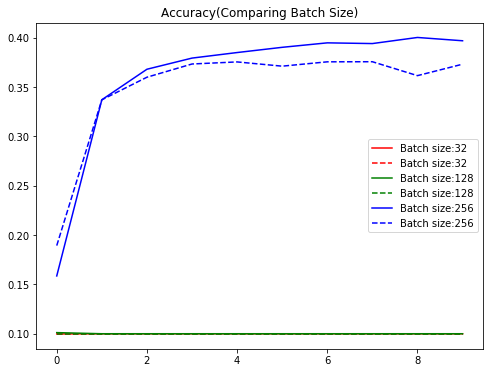

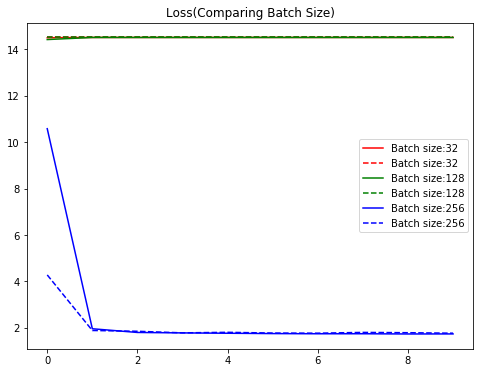

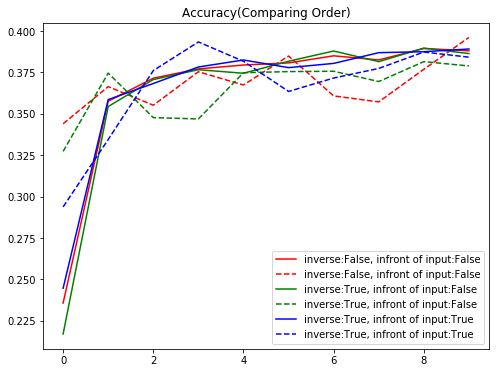

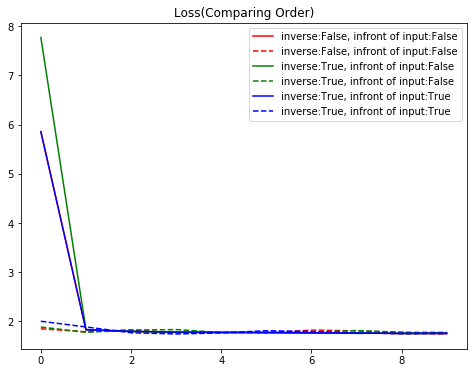

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
def graph(results, title):
  colors = ['r', 'g', 'b', 'y', 'b']

  plt.figure(figsize = (8, 6))
  for i, key in enumerate(results.keys()):
    plt.plot(range(len(results[key]['acc'])), results[key]['acc'], '-', color = colors[i], label = key)
    plt.plot(range(len(results[key]['val_acc'])), results[key]['val_acc'], '--', color = colors[i], label = key)
  plt.title('Accuracy(%s)'%title)
  plt.legend()
  plt.show()

  plt.figure(figsize = (8, 6))
  for i, key in enumerate(results.keys()):
    plt.plot(range(len(results[key]['loss'])), results[key]['loss'], '-', color = colors[i], label = key)
    plt.plot(range(len(results[key]['val_loss'])), results[key]['val_loss'], '--', color = colors[i], label = key)
  plt.title('Loss(%s)'%title)
  plt.legend()
  plt.show()

graph(results, 'Comparing Batch Size')
graph(results_2, 'Comparing Order')